In [1]:
import json
import os, glob

from itertools import product

import numpy as np
import pandas as pd

import torch

import matplotlib.pyplot as plt

import librosa
import torchaudio

from torchaudio.functional.filtering import lowpass_biquad, highpass_biquad
from torchaudio.transforms import Spectrogram, AmplitudeToDB, MelSpectrogram
from synth.synth_constants import synth_structure
from synth.synth_modules import ADSR


from matplotlib import rcParams

from collections import defaultdict

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import seaborn as sns

from config import Config
from synth.synth_architecture import SynthModular

from IPython.display import Audio, display
from ipywidgets import interactive, interact_manual, FloatSlider, interact
import ipywidgets as widgets

sns.set_style('whitegrid')

n_fft = 1024
win_length = None
hop_length = 512

# Define transform
spectrogram = Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)

n_mels = 128

mel_spectrogram = MelSpectrogram(
    sample_rate=synth_structure.sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

# spectrogram = Spectrogram(n_fft=1024)
db = AmplitudeToDB(stype='magnitude')

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", db=True):
    fig, axs = plt.subplots(1, 1, figsize=(30, 10))
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    if db:
        im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", cmap='inferno')
    else:
        im = axs.imshow(specgram, origin="lower", aspect="auto", cmap='inferno')
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

signal_duration = 4
device = 'cuda:0'
batch_size=1


In [2]:
semitones_list = [*range(-24, 24 + 1)]
middle_c_freq= 261.6255653005985
osc_freq_list = [middle_c_freq * (2 ** (1 / 12)) ** x for x in semitones_list]
osc_freq_list

[65.40639132514956,
 69.29565774421792,
 73.41619197935178,
 77.78174593052012,
 82.40688922821737,
 87.30705785825086,
 92.49860567790849,
 97.9988589954372,
 103.82617439498617,
 109.99999999999989,
 116.54094037952234,
 123.4708253140309,
 130.81278265029917,
 138.59131548843592,
 146.83238395870364,
 155.56349186104032,
 164.81377845643482,
 174.6141157165018,
 184.99721135581706,
 195.9977179908745,
 207.65234878997242,
 219.99999999999986,
 233.08188075904485,
 246.94165062806192,
 261.6255653005985,
 277.18263097687196,
 293.6647679174074,
 311.1269837220808,
 329.62755691286986,
 349.22823143300377,
 369.9944227116343,
 391.9954359817492,
 415.30469757994507,
 439.99999999999994,
 466.1637615180899,
 493.8833012561241,
 523.2511306011972,
 554.3652619537442,
 587.3295358348153,
 622.253967444162,
 659.2551138257401,
 698.4564628660079,
 739.9888454232689,
 783.9908719634988,
 830.6093951598906,
 880.0000000000003,
 932.3275230361803,
 987.7666025122487,
 1046.5022612023952]

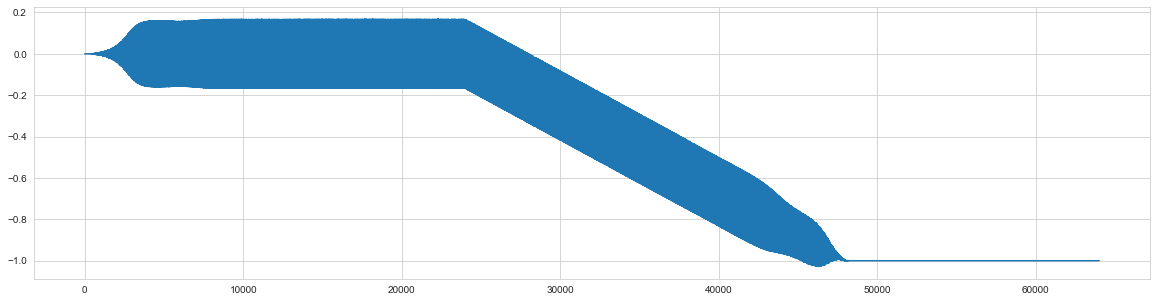

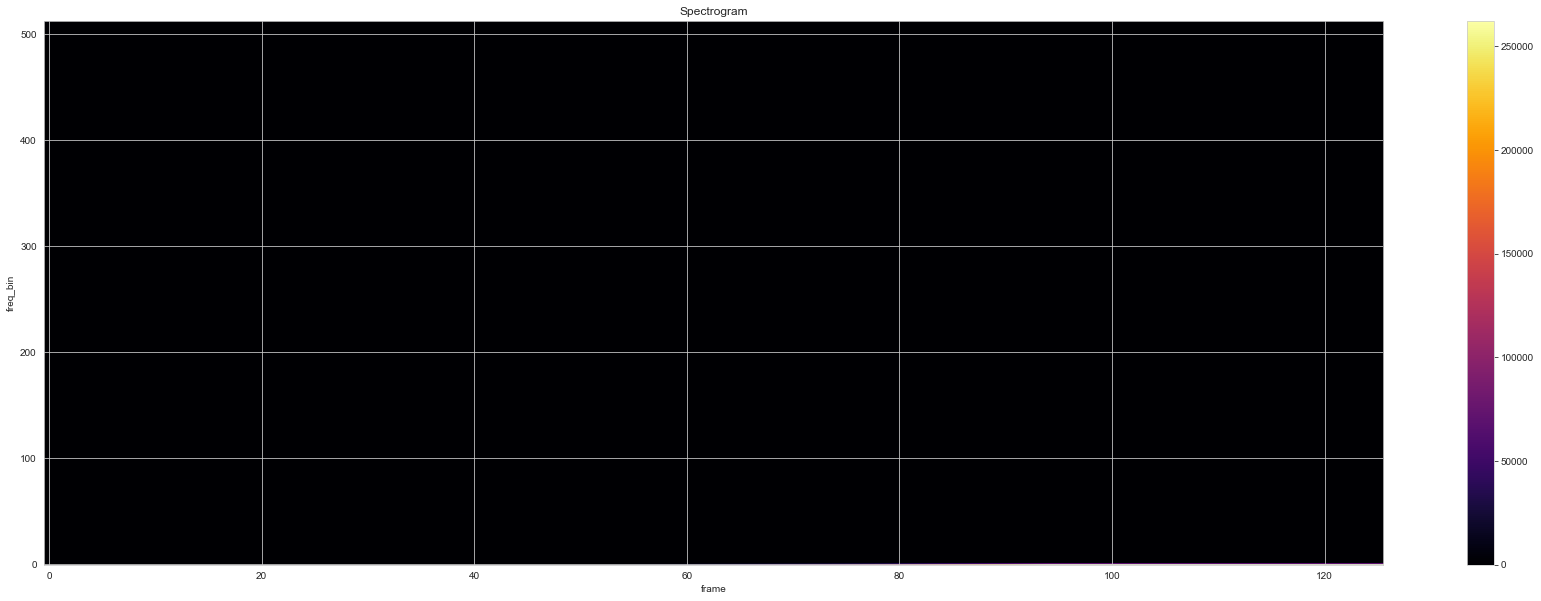

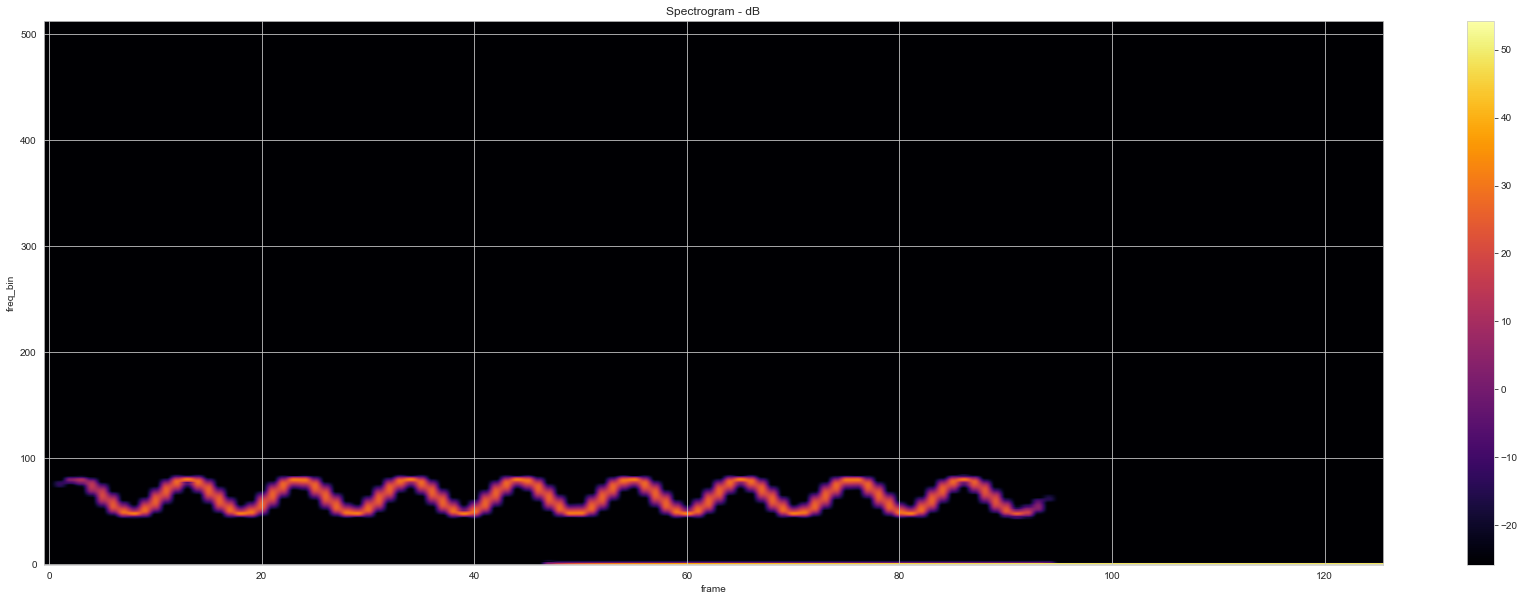

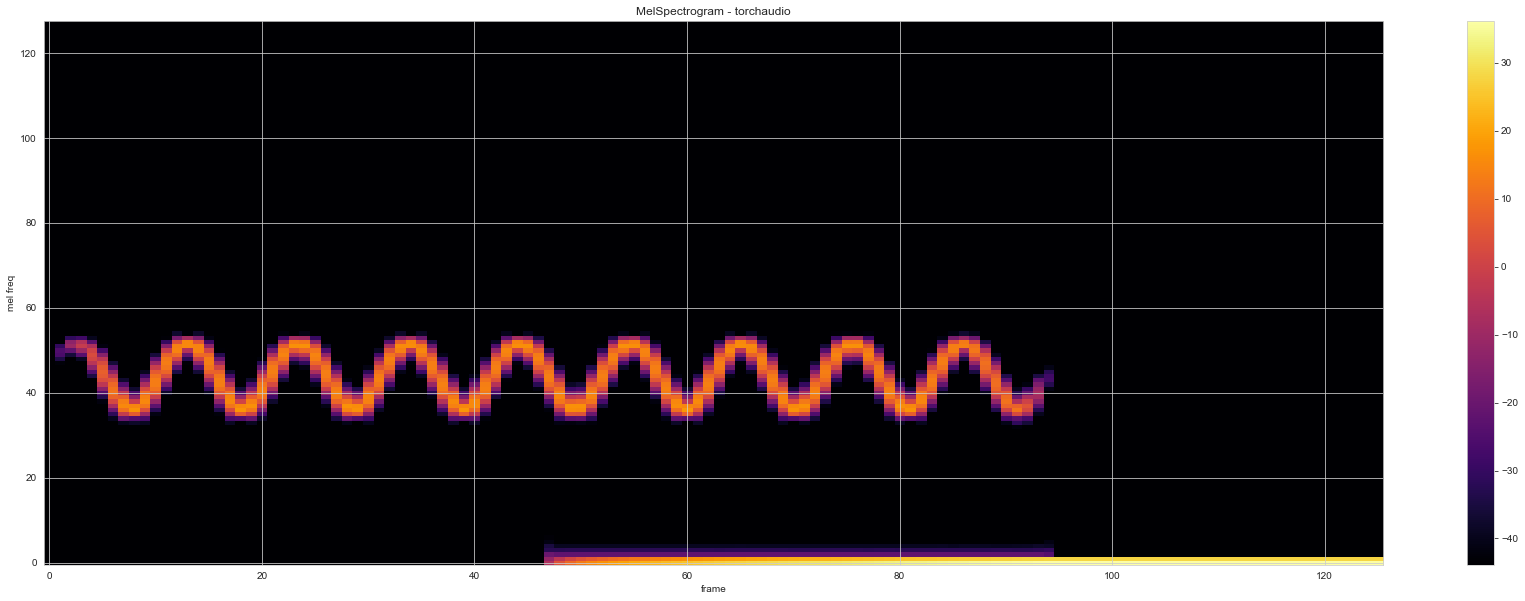

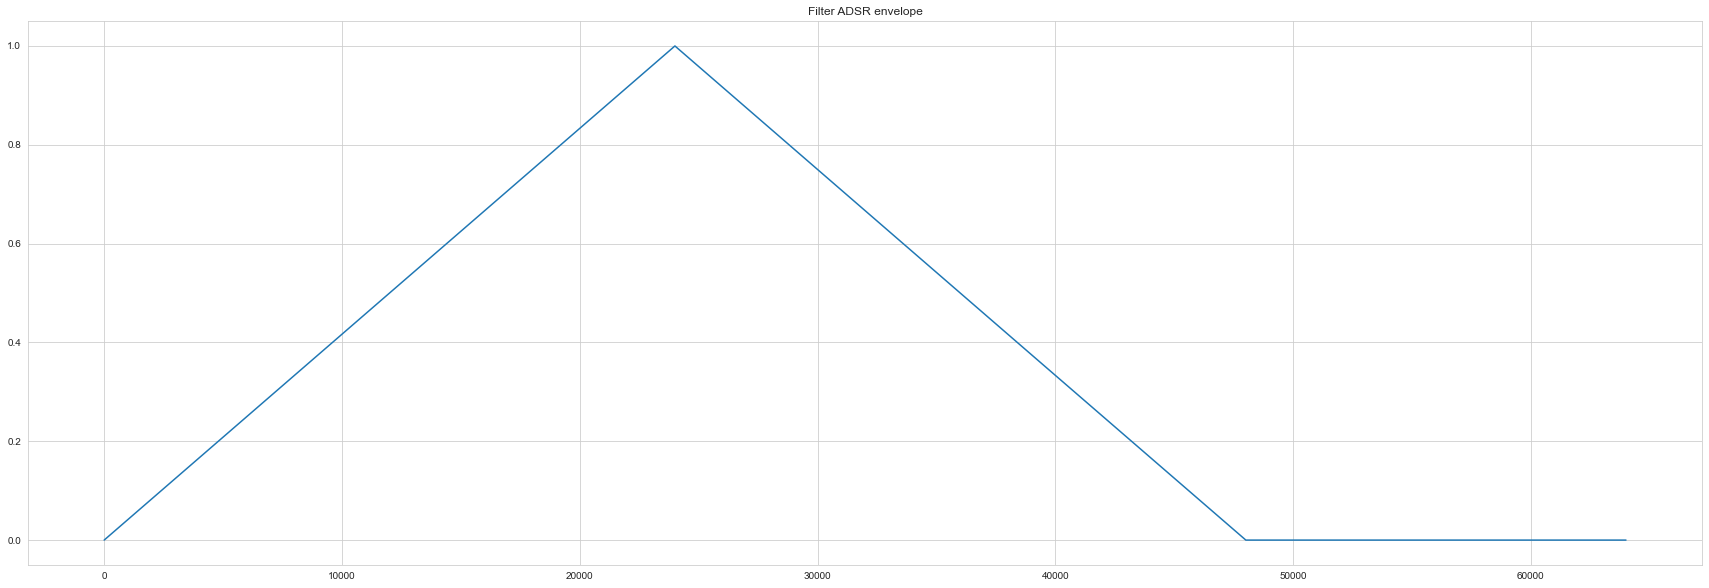

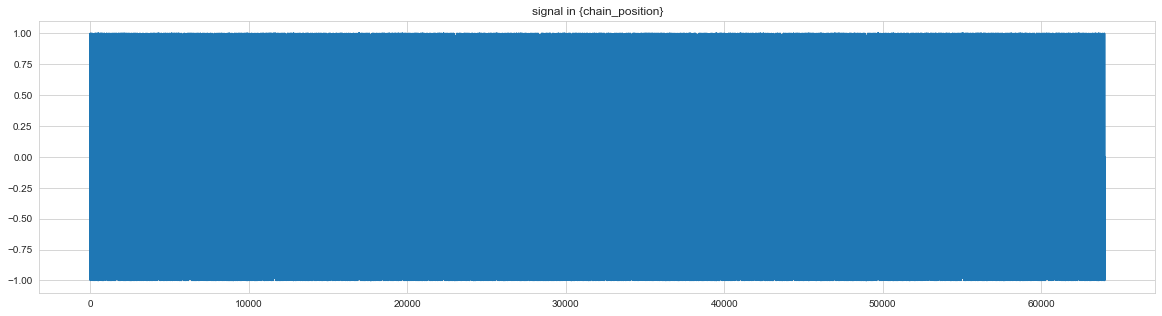

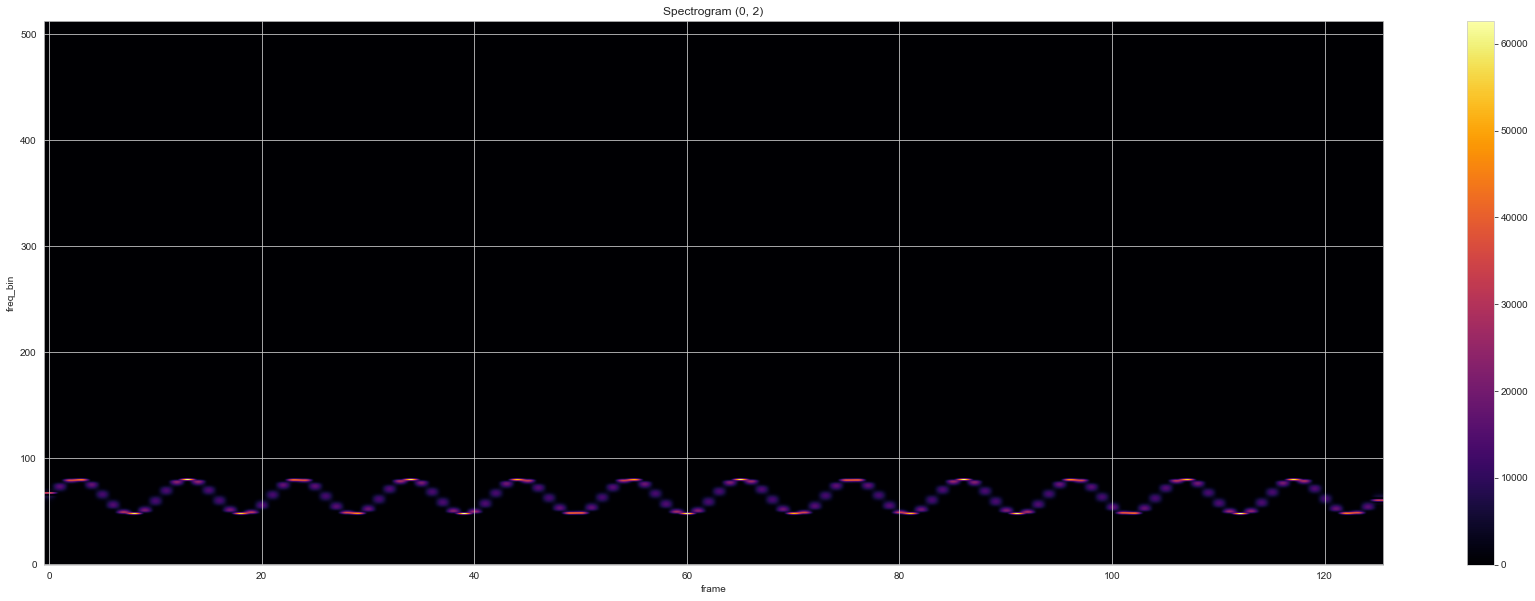

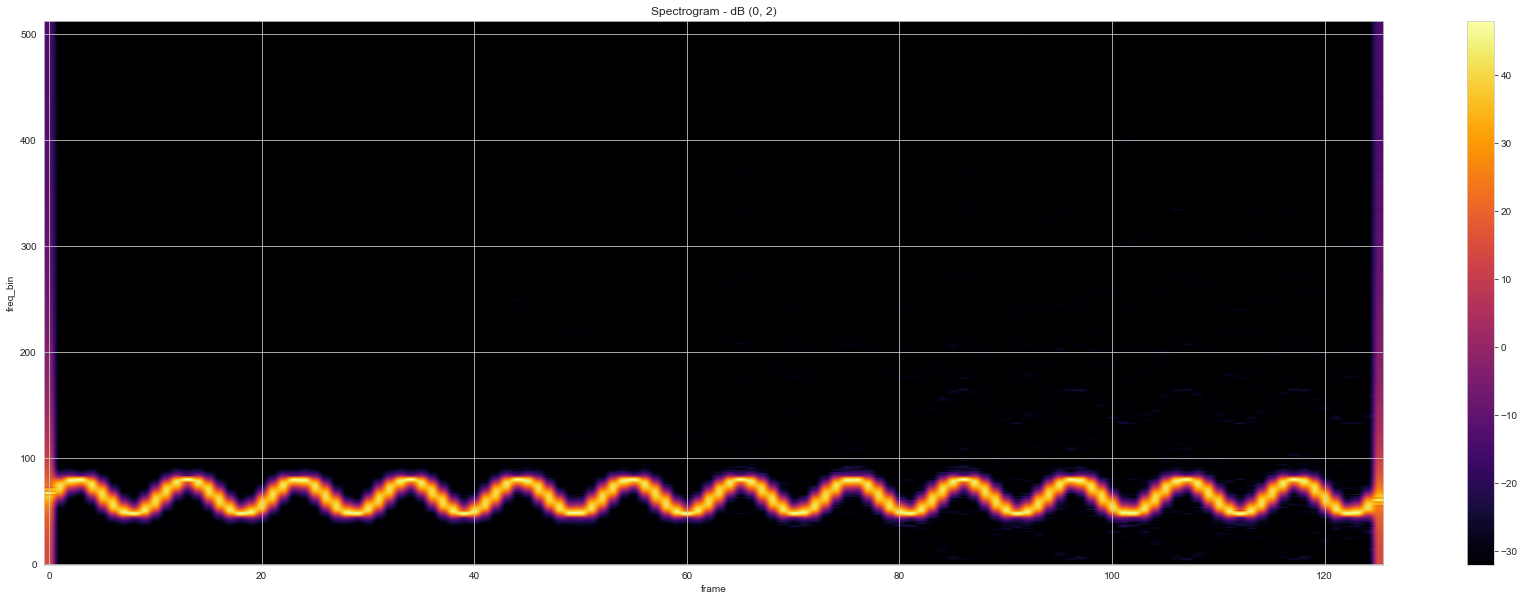

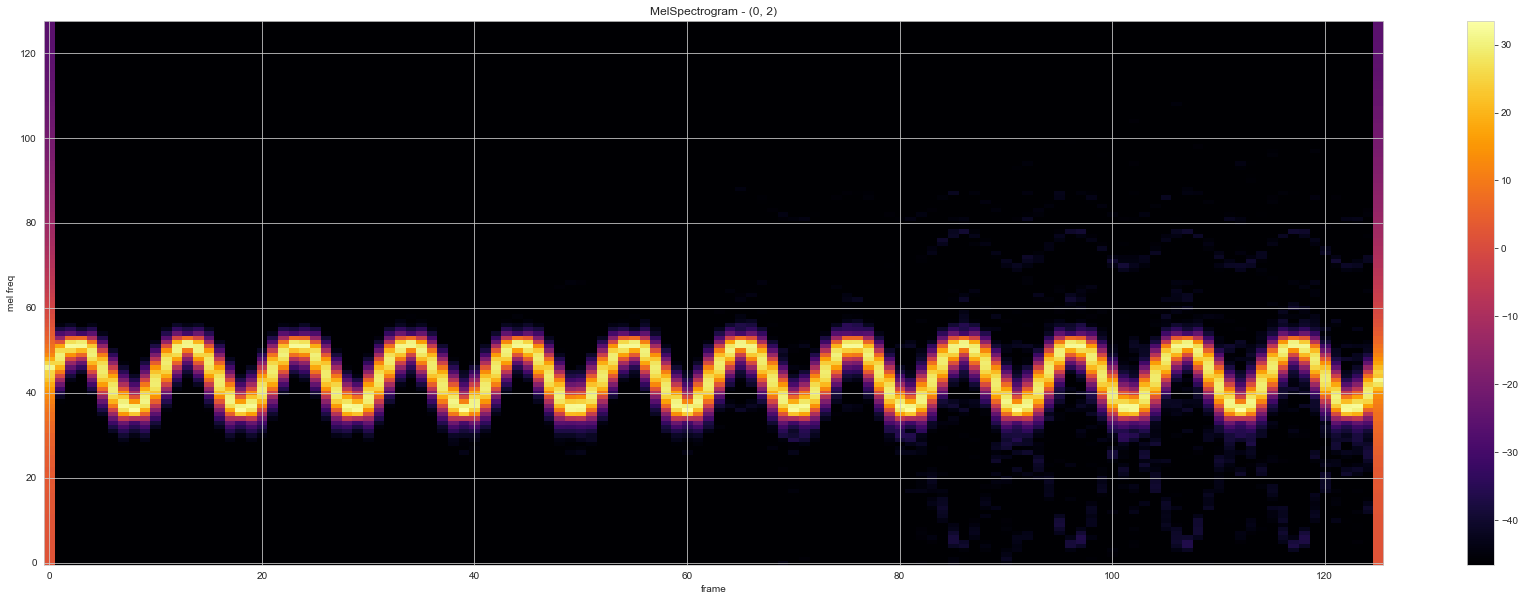

In [28]:
synth_obj = SynthModular(preset_name='MODULAR_NEW', synth_structure=synth_structure, device='cpu')

params = {(0,0): {'operation': 'lfo_sine', 'parameters': {'freq': [1], 'amp': [1], 'active': [False], 'output': [[0, 6]]}},
          (1,1): {'operation': 'fm_lfo', 'parameters': {'freq_c': [3], 'waveform': ['sine'], 'mod_index': [0], 'amp_c': [1], 'active': [True], 'fm_active': [False], 'output': [[0, 2]]}},
          (0,2): {'operation': 'fm_sine', 'parameters': {'amp_c': [1], 'freq_c': [1000], 'mod_index': [0.1], 'active': [True], 'fm_active': [True]}},
          (1,2): {'operation': 'fm_saw', 'parameters': {'amp_c': [1], 'freq_c': [750], 'mod_index': [0.1], 'active': [False], 'fm_active': [False]}},
          (2,2): {'operation': 'fm_square', 'parameters': {'amp_c': [1], 'freq_c': [1000], 'mod_index': [0.1], 'active': [False], 'fm_active': [False]}},
          (0,3): {'operation': 'mix', 'parameters': {}},
          (0,4): {'operation': 'env_adsr', 'parameters': {'attack_t': [0], 'decay_t': [0], 'sustain_t': [3], 'sustain_level': [0.5], 'release_t': [1]}},
          (0,5): {'operation': 'lowpass_filter_adsr', 'parameters': {'attack_t': [1.5], 'decay_t': [1.5], 'sustain_t': [0], 'sustain_level': [0], 'release_t': [0], 'filter_freq': [0], 'intensity': [1]}},
          (0,6): {'operation': 'tremolo', 'parameters': {'amount': [0], 'active': [False], 'fm_active': [False]}}
          }

synth_obj.update_cells_from_dict(params)
final_signal, output_signals_through_chain_dict = synth_obj.generate_signal(signal_duration=signal_duration, batch_size=1)
sound = final_signal.detach().cpu()[0]

spec = spectrogram(sound)
db_spec = db(spec)
melspec = mel_spectrogram(sound.float())

audio = Audio(sound.numpy(), rate=synth_structure.sample_rate, autoplay=False)
display(audio)

fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(sound.numpy())

plot_spectrogram(spec, title="Spectrogram", db=False)
plot_spectrogram(spec, title="Spectrogram - dB")
plot_spectrogram(melspec, title="MelSpectrogram - torchaudio", ylabel="mel freq")

adsr_shape = ADSR(params=params[(0,5)]['parameters'], sample_rate=synth_structure.sample_rate, signal_duration=signal_duration,
                          device=device, synth_structure=synth_structure, batch_size=batch_size)
envelope = adsr_shape.envelope[0]

fig2, ax2 = plt.subplots(1, 1, figsize=(30, 10))
ax2.plot(envelope.detach().cpu().numpy())
plt.title('Filter ADSR envelope')


# Signal Though chain
chain_position = '(0, 2)'

chain_output = output_signals_through_chain_dict[chain_position]
chain_sound = chain_output.detach().cpu()[0]

chain_spec = spectrogram(chain_sound)
chain_db_spec = db(chain_spec)
chain_melspec = mel_spectrogram(chain_sound.float())

chain_audio = Audio(chain_sound.numpy(), rate=synth_structure.sample_rate, autoplay=False)
display(chain_audio)

fig3, ax3 = plt.subplots(1, 1, figsize=(20, 5))
ax3.plot(chain_sound.numpy())
plt.title(r"signal in {chain_position}")

plot_spectrogram(chain_spec, title=f"Spectrogram {chain_position}", db=False)
plot_spectrogram(chain_spec, title=f"Spectrogram - dB {chain_position}")
plot_spectrogram(chain_melspec, title=f"MelSpectrogram - {chain_position}", ylabel="mel freq")


# NOTES:
# debug filter adsr - debug different timings and watch for result
# show signals through chain

In [ ]:
window = torch.hann_window(1024, requires_grad=True)
zeros = torch.zeros(512)

a = torch.ones(2048)
b = a.unfold(dimension=0, size=1024, step=512)
filtered = b * window

f1 = torch.cat((filtered[0], torch.zeros(512*2)))
f2 = torch.cat((torch.zeros(512), filtered[1], torch.zeros(512)))
f3 = torch.cat((torch.zeros(512*2), filtered[2]))
# second = torch.cat((zeros, window, zeros))
# third = torch.cat((zeros, zeros, window))
#
full = f1 + f2 + f3

fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(full.detach().cpu().numpy())
